# Aspirational Logistic Regression Models Using Merged Data Experiment 1.1

In [2]:
import pandas as pd
import numpy as np
import random
import re
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import csv
import pickle
import warnings
import stanza

from nltk import word_tokenize,pos_tag
from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from textblob import TextBlob
from collections import Counter
from gensim.models import Word2Vec

from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, f1_score, r2_score, make_scorer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

# Set random seed
random.seed(18)
seed = 18

# Ignore warnings
warnings.filterwarnings('ignore')

# Display options
pd.set_option('display.max_colwidth', None)

# Initialize lemmatizer, stop words, and stanza
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))
stanza.download('en') # download English model
nlp = stanza.Pipeline('en') # initialize English neural pipeline


2024-10-06 15:37:04 INFO: Downloaded file to /Users/gbaldonado/stanza_resources/resources.json
2024-10-06 15:37:04 INFO: Downloading default packages for language: en (English) ...
2024-10-06 15:37:05 INFO: File exists: /Users/gbaldonado/stanza_resources/en/default.zip
2024-10-06 15:37:08 INFO: Finished downloading models and saved to /Users/gbaldonado/stanza_resources
2024-10-06 15:37:08 INFO: Checking for updates to resources.json in case models have been updated.  Note: this behavior can be turned off with download_method=None or download_method=DownloadMethod.REUSE_RESOURCES


2024-10-06 15:37:08 INFO: Downloaded file to /Users/gbaldonado/stanza_resources/resources.json
2024-10-06 15:37:09 INFO: Loading these models for language: en (English):
| Processor    | Package                   |
--------------------------------------------
| tokenize     | combined                  |
| mwt          | combined                  |
| pos          | combined_charlm           |
| lemma        | combined_nocharlm         |
| constituency | ptb3-revised_charlm       |
| depparse     | combined_charlm           |
| sentiment    | sstplus_charlm            |
| ner          | ontonotes-ww-multi_charlm |

2024-10-06 15:37:09 INFO: Using device: cpu
2024-10-06 15:37:09 INFO: Loading: tokenize
2024-10-06 15:37:09 INFO: Loading: mwt
2024-10-06 15:37:09 INFO: Loading: pos
2024-10-06 15:37:10 INFO: Loading: lemma
2024-10-06 15:37:10 INFO: Loading: constituency
2024-10-06 15:37:10 INFO: Loading: depparse
2024-10-06 15:37:10 INFO: Loading: sentiment
2024-10-06 15:37:10 INFO: Loading: 

## 1. Loading the data and quick exploratory data analysis

In [3]:
merged_aspirational_df = pd.read_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/processed_for_model/merged_themes_using_jaccard_method/merged_Aspirational_sentence_level_batch_1_jaccard.csv", encoding='utf-8')

# Shuffle the merged dataset
merged_aspirational_df = shuffle(merged_aspirational_df, random_state=seed)

# Train-test split 
training_df, test_df = train_test_split(merged_aspirational_df, test_size=0.1, random_state=18, stratify=merged_aspirational_df['label'])

training_df.reset_index(drop=True, inplace=True)
test_df.reset_index(drop=True, inplace=True)

In [4]:
training_df.head()

,sentence,label,phrase
0,i am a computer engineering major that wants to get my degree and have to take this class to fulfill my requirements.,1,['I am a computer engineering major that wants to get my degree']
1,i am here to help the environment!,0,['I plan to enter a field of environmental sciences and zoology once I graduate.']
2,i am here to build my future.,0,"['I am here to build my future. I want to have a good future for myself, where I can maintain myself as well as doing what I love to do.']"
3,"and i wouldnt be here without the support of friends and family so in answering the question, why am i here. i have to credit them with some consideration in my answer as well.",0,['Id say Im here to get an education and try to work my way towards being a doctor which is something I aspire to be.']
4,"like understand velocity, acceleration and displacement to determine the motion of an object.",0,['Also I want to be an optometrist and this class is part of that journey.']


In [5]:
test_df.head()

,sentence,label,phrase
0,yes they did encourage and force me to choose my major but i do find interest in it.,0,"['I want to live to my full potential not anyone who has talent and knowledge and not apply it to their life. I want to do that by implementing these qualities to my daily life to become who I want to be. I want to be an Engineering for the future.', 'I dont want to be known as that person who is something in particular. I want to be known as that person who is something and did something about it. I want a title but the authority to be that person.']"
1,thats why i am here.,0,['I want to try to get into veterinary school that is why I am in OCHEM.']
2,it's funny because ive never been happier than i ever been because of everything ive been doing lately.,0,['The only way that Im able to create a better future for my community is by getting a PhD']
3,"my family is very bug on education, so everyone generally aspires to go to college.",0,"['For me personally, I am here to learn more about STEM so I can gain the tools to equip me for medical school']"
4,the implications of the amount of work and dedication that vet school required didnt fully hit me until i was in high school.,0,['I am looking forward to learning and strengthening my knowledge on this subject.']


In [6]:
print(f"Training dataset shape: {training_df.shape} \nTest dataset shape: {test_df.shape}")
pos_labels = len([n for n in training_df['label'] if n==1])
print("Positive labels present in the dataset : {}  out of {} or {}%".format(pos_labels, len(training_df['label']), (pos_labels/len(training_df['label']))*100))
pos_labels = len([n for n in test_df['label'] if n==1])
print("Positive labels present in the test dataset : {}  out of {} or {}%".format(pos_labels, len(test_df['label']), (pos_labels/len(test_df['label']))*100))

Training dataset shape: (4233, 3) 
Test dataset shape: (471, 3)
Positive labels present in the dataset : 529  out of 4233 or 12.497047011575715%
Positive labels present in the test dataset : 59  out of 471 or 12.526539278131635%


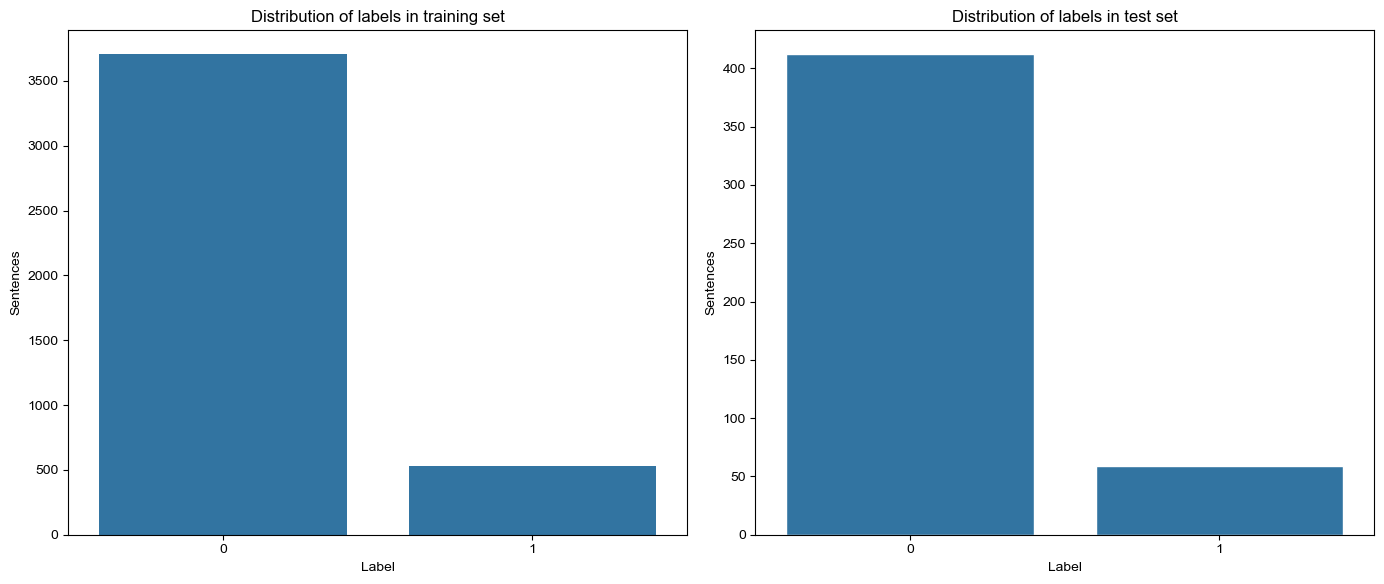

In [7]:
# Generate the data for the plots
training_counts = training_df['label'].value_counts()
test_counts = test_df['label'].value_counts()

# Set up the subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot for the training set
sns.barplot(x=training_counts.index, y=training_counts.values, ax=axes[0])
axes[0].set_title('Distribution of labels in training set')
axes[0].set_ylabel('Sentences')
axes[0].set_xlabel('Label')
sns.set(style="whitegrid")

# Plot for the test set
sns.barplot(x=test_counts.index, y=test_counts.values, ax=axes[1])
axes[1].set_title('Distribution of labels in test set')
axes[1].set_ylabel('Sentences')
axes[1].set_xlabel('Label')
sns.set(style="whitegrid")

# Adjust layout to prevent overlap
plt.tight_layout()

# Show the plots
plt.show()

## 2. Feature Engineering

### 1. NER

In [8]:
def get_ner(text):
    ner_list = []
    # Annotate the text using stanza
    doc = nlp(text)

    for sentence in doc.sentences:
        for entity in sentence.ents:
            if entity.type == 'PERSON':
                ner_list.append(entity.text)

    return ner_list

# Example usage
text = "Barack Obama was the 44th doctor of the United States."
print(get_ner(text))

['Barack Obama']


In [9]:
# check if a named entity is present in the sentence
def named_entity_present(sentence):
    ner_list = get_ner(sentence)
    if len(ner_list) > 0:
        return 1
    else:
        return 0

### 2. Similarity Features

In [10]:
# A helper function to get the similar words and similarity score
# The function takes tokens of sentence as input and if its not a stop word, get its similarity with synsets of STEM.
stop_words = set(stopwords.words('english'))
stop_words |= set(["help","try", "work", "process", "support", "job"] )
def word_similarity(tokens, syns, field):    
    if field in ['engineering', 'technology']:
        score_threshold = 0.5
    else:
        score_threshold = 0.2
    sim_words = 0
    for token in tokens:
        if token not in stop_words:
            try:
                syns_word = wordnet.synsets(token) 
                score = syns_word[0].path_similarity(syns[0])
                if score >= score_threshold:
                    sim_words += 1
            except: 
                score = 0
    
    return sim_words

In [11]:
# Functions to create columns for similarity based on all STEM fields
syns_bio = wordnet.synsets(lemmatizer.lemmatize("biology"))
syns_maths = wordnet.synsets(lemmatizer.lemmatize("mathematics")) 
syns_tech = wordnet.synsets(lemmatizer.lemmatize("technology"))
syns_eng = wordnet.synsets(lemmatizer.lemmatize("engineering"))
syns_chem = wordnet.synsets(lemmatizer.lemmatize("chemistry"))
syns_phy = wordnet.synsets(lemmatizer.lemmatize("physics"))
syns_sci = wordnet.synsets(lemmatizer.lemmatize("science"))

### 3. Medical Word Count

In [12]:
# Load the medical specialization text file and create a list
medical_list = []
with open('/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/features/medical_specialities.txt', 'r') as medical_fields:
    for line in medical_fields.readlines():
        special_field = line.rstrip('\n')
        special_field = re.sub("\W"," ", special_field )
#         print(special_field)
        medical_list += special_field.split()
medical_list = list(set(medical_list))  
medical_list = [x.lower() for x in medical_list]
print(medical_list)

['clinical', 'reconstructive', 'interventional', 'metabolism', 'abuse', 'neuromuscular', 'physical', 'advanced', 'endovascular', 'dermatology', 'oculoplastics', 'cardiology', 'female', 'infectious', 'neurology', 'medicine', 'developmental', 'gastroenterology', 'consultation', 'ophthalmology', 'pathology', 'pelvic', 'pain', 'neurodevelopmental', 'neurourology', 'administrative', 'endocrinology', 'chest', 'palliative', 'surgical', 'gynecology', 'internal', 'urology', 'infectious', 'neuroradiology', 'and', 'sleep', 'rheumatology', 'neck', 'nephrology', 'child', 'cardiovascular', 'nephrology', 'anterior', 'cornea', 'critical', 'cardiothoracic', 'ocular', 'perinatal', 'retardation', 'glaucoma', 'male', 'anesthesiology', 'musculoskeletal', 'imaging', 'electrophysiology', 'genitourinary', 'uveitis', 'pulmonology', 'forensic', 'neuro', 'oncology', 'sports', 'pathology', 'failure', 'community', 'mental', 'public', 'addiction', 'radiation', 'dermatology', 'banking', 'immunopathology', 'adolescen

In [13]:
# A helper function to get medical words
def check_medical_words(tokens):
    for token in tokens:
        if token not in stop_words and token in [x.lower() for x in medical_list]:
            return 1
        
    return 0

### 4. Sentiment Polarity and Subjectivity

In [14]:
# A helper function to get polarity and subjectivity of the sentence using TexBlob
def get_sentiment(sentence):
    sentiments =TextBlob(sentence).sentiment
    polarity = sentiments.polarity
    subjectivity = sentiments.subjectivity
    return polarity, subjectivity

### 5. POS Tag Count

In [15]:
# A helper function to get the count of POS tags of the sentence
def count_pos_tags(tokens):
    token_pos = pos_tag(tokens)
    count = Counter(tag for word,tag in token_pos)
    interjections =  count['UH']
    nouns = count['NN'] + count['NNS'] + count['NNP'] + count['NNPS']
    adverb = count['RB'] + count['RBS'] + count['RBR']
    verb = count['VB'] + count['VBD'] + count['VBG'] + count['VBN']
    determiner = count['DT']
    pronoun = count['PRP']
    adjetive = count['JJ'] + count['JJR'] + count['JJS']
    preposition = count['IN']
    return interjections, nouns, adverb, verb, determiner, pronoun, adjetive,preposition

In [16]:
def pos_tag_extraction(dataframe, field, func, column_names):
    return pd.concat((
        dataframe,
        dataframe[field].apply(
            lambda cell: pd.Series(func(cell), index=column_names))), axis=1)

### 6. Word Embeddings

In [17]:
# Load the w2v dict from pickle file
with open('/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/data/features/pickle/embeddings06122024.pickle', 'rb') as w2v_file:
    w2v_dict = pickle.load(w2v_file)

In [18]:
print("length of word embeddings: ", len(w2v_dict.keys()))

length of word embeddings:  4762


In [19]:
# Get the vectors for the essay
def vectorizer(sequence):
    vect = []
    numw = 0
    for w in sequence: 
        try :
            if numw == 0:
                vect = w2v_dict[w]
            else:
                vect = np.add(vect, w2v_dict[w])
            numw += 1
        except Exception as e:
            pass

    return vect/ numw 

In [20]:
# Function to split text into words
def split_into_words(text):
    return text.split()

### 7. Unigrams

In [6]:
# Define the vectorizer
unigram_vect = CountVectorizer(ngram_range=(1, 1), min_df=2, stop_words = 'english')

### 8. Putting them all together

In [22]:
# Wrapper function for feature engineering
def feature_engineering(original_dataset):

    dataset = original_dataset.copy()
    # create a new column with sentence tokens
    dataset['tokens'] = dataset['sentence'].apply(word_tokenize)
    # 1. Similarity features
    # biology
    dataset['bio_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_bio,'biology',)) 
    # chemistry
    dataset['chem_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_chem,'chemistry',))
    # physics
    dataset['phy_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_phy,'physics',))
    # mathematics
    dataset['math_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_maths,'mathematics',))
    # technology
    dataset['tech_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_tech,'technology',))
    # engineering
    dataset['eng_sim_words'] = dataset['tokens'].apply(word_similarity, args=(syns_eng,'engineering',))
    
    # medical terms
    dataset['medical_terms'] = dataset['tokens'].apply(check_medical_words)
    
    # polarity and subjectivity
    dataset['polarity'], dataset['subjectivity'] = zip(*dataset['sentence'].apply(get_sentiment))
    
    # named entity recognition
    dataset['ner'] = dataset['sentence'].apply(named_entity_present)
    
    # pos tag count
    dataset = pos_tag_extraction(dataset, 'tokens', count_pos_tags, ['interjections', 'nouns', 'adverb', 'verb', 'determiner', 'pronoun', 'adjetive','preposition'])
    
    # labels
    data_labels = dataset['label']
    # X
    data_x = dataset.drop(columns='label')

    
    # vectorize all the essays
    vect_arr = data_x.tokens.apply(vectorizer)
    for index in range(0, len(vect_arr)):
        i = 0
        for item in vect_arr[index]:
            column_name= "embedding" + str(i)
            data_x.loc[index, column_name] = item
            i +=1
    
    return data_x,data_labels
    

In [22]:
X_train, y_train = feature_engineering(training_df)

In [23]:
X_train.shape

(4233, 121)

In [24]:
y_train = y_train.astype('int')

In [23]:
X_test, y_test = feature_engineering(test_df)

In [26]:
X_test.shape

(471, 121)

In [27]:
y_test = y_test.astype('int')

**Calculate Unigram features for both train and test set**

In [28]:
X_train.shape

(4233, 121)

In [29]:
X_test.shape

(471, 121)

In [24]:
X_test.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_1.1/Aspirational/saved_features/X_test_final.csv", index=False)

In [1]:
X_train.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_1.1/Aspirational/saved_features/X_train_final.csv", index=False)
X_test.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_1.1/Aspirational/saved_features/X_test_final.csv", index=False)
y_train.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_1.1/Aspirational/saved_features/y_train.csv", index=False)
y_test.to_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_1.1/Aspirational/saved_features/y_test.csv", index=False)


NameError: name 'X_train' is not defined

In [3]:
X_train = pd.read_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_1.1/Aspirational/saved_features/X_train_final.csv")
X_test = pd.read_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_1.1/Aspirational/saved_features/X_test_final.csv")
y_train = pd.read_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_1.1/Aspirational/saved_features/y_train.csv")
y_test = pd.read_csv("/Users/gbaldonado/Developer/ml-alma-taccti/ml-alma-taccti/notebooks/experiments/exp_1.1/Aspirational/saved_features/y_test.csv")

In [7]:
# Unigrams for training set
unigram_matrix = unigram_vect.fit_transform(X_train['sentence'])
unigrams = pd.DataFrame(unigram_matrix.toarray())
print("Shape of the unigram df for train : ",unigrams.shape)
unigrams = unigrams.reset_index(drop=True)

Shape of the unigram df for train :  (4233, 2308)


In [8]:
X_train_final = pd.concat([X_train, unigrams], axis = 1)

In [9]:
X_train_final.columns = X_train_final.columns.astype(str)

In [10]:
X_train_final.shape

(4233, 2429)

In [11]:
unigram_matrix_test = unigram_vect.transform(X_test['sentence'])
unigrams_test = pd.DataFrame(unigram_matrix_test.toarray())
unigrams_test = unigrams_test.reset_index(drop=True)
print("Test unigram df shape : ",unigrams_test.shape)

Test unigram df shape :  (471, 2308)


In [12]:
X_test_final = pd.concat([X_test, unigrams_test], axis = 1)
X_test_final.shape

(471, 2429)

In [13]:
X_test_final.columns = X_test_final.columns.astype(str)

In [14]:
X_test_final.shape

(471, 2429)

In [15]:
for i in range(0, len(X_train_final.columns)):
    print('{} ---- {}'.format(i, X_train_final.columns[i]))

0 ---- sentence
1 ---- phrase
2 ---- tokens
3 ---- bio_sim_words
4 ---- chem_sim_words
5 ---- phy_sim_words
6 ---- math_sim_words
7 ---- tech_sim_words
8 ---- eng_sim_words
9 ---- medical_terms
10 ---- polarity
11 ---- subjectivity
12 ---- ner
13 ---- interjections
14 ---- nouns
15 ---- adverb
16 ---- verb
17 ---- determiner
18 ---- pronoun
19 ---- adjetive
20 ---- preposition
21 ---- embedding0
22 ---- embedding1
23 ---- embedding2
24 ---- embedding3
25 ---- embedding4
26 ---- embedding5
27 ---- embedding6
28 ---- embedding7
29 ---- embedding8
30 ---- embedding9
31 ---- embedding10
32 ---- embedding11
33 ---- embedding12
34 ---- embedding13
35 ---- embedding14
36 ---- embedding15
37 ---- embedding16
38 ---- embedding17
39 ---- embedding18
40 ---- embedding19
41 ---- embedding20
42 ---- embedding21
43 ---- embedding22
44 ---- embedding23
45 ---- embedding24
46 ---- embedding25
47 ---- embedding26
48 ---- embedding27
49 ---- embedding28
50 ---- embedding29
51 ---- embedding30
52 ---- em

### Model 1: Unigrams, POS Tag Count, Sentiment Polarity, Subjectivity

In [16]:
X_train_model_1 = X_train_final.iloc[:,np.r_[10:12,13:21,121:2429]]

In [17]:
X_train_model_1.shape

(4233, 2318)

In [18]:
X_test_model_1 = X_test_final.iloc[:,np.r_[10:12,13:21,121:2429]]

In [19]:
X_test_model_1.shape

(471, 2318)

In [23]:
from sklearn.metrics import classification_report, average_precision_score

model_1_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_1_pipeline, parameters, scoring="average_precision", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_1,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    
# Calculate and print the average precision score
avg_precision = average_precision_score(y_test, grid_search.best_estimator_.predict_proba(X_test_model_1)[:, 1])
print(f'Average Precision: {avg_precision:.4f}')

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_1), digits=4))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning

Best score: 0.351
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
Average Precision: 0.4413
              precision    recall  f1-score   support

           0     0.9460    0.8083    0.8717       412
           1     0.3361    0.6780    0.4494        59

    accuracy                         0.7919       471
   macro avg     0.6411    0.7431    0.6606       471
weighted avg     0.8696    0.7919    0.8188       471



In [74]:
lr_model_1 = LogisticRegression(random_state=18, 
                                solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], 
                                class_weight='balanced').fit(X_train_model_1, y_train)
y_lr = lr_model_1.predict(X_test_model_1)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

# Calculate and print the average precision score
avg_precision = average_precision_score(y_test, y_lr)
print(f'Average Precision: {avg_precision:.4f}')

Logistic regression Classifier
True Negative: 333, False Positive: 79, False Negative: 19, True Positive: 40
--------------------------------------------------------------------------------
[[333  79]
 [ 19  40]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.81      0.87       412
           1       0.34      0.68      0.45        59

    accuracy                           0.79       471
   macro avg       0.64      0.74      0.66       471
weighted avg       0.87      0.79      0.82       471

Average Precision: 0.2682


### Model 2: All Features

In [75]:
# X_train_model_2 = X_train_final.iloc[:,np.r_[3:1113]]
X_train_model_2 = X_train_final.iloc[:, np.r_[3:2429]]

In [76]:
X_train_model_2.shape

(4233, 2426)

In [77]:
X_test_model_2 = X_test_final.iloc[:,np.r_[3:2429]]

In [78]:
X_test_model_2.shape

(471, 2426)

In [79]:
model_2_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_2_pipeline, parameters, scoring="average_precision", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_2,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    


print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_2), digits=4))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning

Best score: 0.363
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.9529    0.7864    0.8617       412
           1     0.3282    0.7288    0.4526        59

    accuracy                         0.7792       471
   macro avg     0.6406    0.7576    0.6572       471
weighted avg     0.8747    0.7792    0.8105       471



In [80]:
lr_model_2 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_2, y_train)
y_lr = lr_model_2.predict(X_test_model_2)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

# Calculate and print the average precision score
avg_precision = average_precision_score(y_test, y_lr)
print(f'Average Precision: {avg_precision:.4f}')

Logistic regression Classifier
True Negative: 324, False Positive: 88, False Negative: 16, True Positive: 43
--------------------------------------------------------------------------------
[[324  88]
 [ 16  43]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.79      0.86       412
           1       0.33      0.73      0.45        59

    accuracy                           0.78       471
   macro avg       0.64      0.76      0.66       471
weighted avg       0.87      0.78      0.81       471

Average Precision: 0.2732


### Model 3: Without Unigrams

In [81]:
X_train_model_3 = X_train_final.iloc[:,np.r_[3:121]]

In [82]:
X_train_model_3.shape

(4233, 118)

In [83]:
X_test_model_3 = X_test_final.iloc[:,np.r_[3:121]]

In [84]:
X_test_model_3.shape

(471, 118)

In [85]:
model_3_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.0001, 0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2", "elasticnet"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_3_pipeline, parameters, scoring="average_precision", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_3,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_3), digits=4))

Fitting 10 folds for each of 18 candidates, totalling 180 fits


/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning

Best score: 0.323
Best parameters set:
	clf__C: 25
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.9508    0.7039    0.8089       412
           1     0.2651    0.7458    0.3911        59

    accuracy                         0.7091       471
   macro avg     0.6079    0.7248    0.6000       471
weighted avg     0.8649    0.7091    0.7566       471



In [86]:
lr_model_3 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_3, y_train)
y_lr = lr_model_3.predict(X_test_model_3)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

# Calculate and print the average precision score
avg_precision = average_precision_score(y_test, y_lr)
print(f'Average Precision: {avg_precision:.4f}')

Logistic regression Classifier
True Negative: 290, False Positive: 122, False Negative: 15, True Positive: 44
--------------------------------------------------------------------------------
[[290 122]
 [ 15  44]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.70      0.81       412
           1       0.27      0.75      0.39        59

    accuracy                           0.71       471
   macro avg       0.61      0.72      0.60       471
weighted avg       0.86      0.71      0.76       471

Average Precision: 0.2295


### Model 4: Without Embeddings

In [87]:
X_train_model_4 = X_train_final.iloc[:,np.r_[3:21,121:2429]]

In [88]:
X_train_model_4.shape

(4233, 2326)

In [89]:
X_test_model_4 = X_test_final.iloc[:,np.r_[3:21,121:2429]]

In [90]:
X_test_model_4.shape

(471, 2326)

In [91]:
model_4_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_4_pipeline, parameters, scoring="average_precision", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_4,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_4), digits=4))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning

Best score: 0.350
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0     0.9460    0.8083    0.8717       412
           1     0.3361    0.6780    0.4494        59

    accuracy                         0.7919       471
   macro avg     0.6411    0.7431    0.6606       471
weighted avg     0.8696    0.7919    0.8188       471



In [92]:
lr_model_4 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_4, y_train)
y_lr = lr_model_4.predict(X_test_model_4)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

# Calculate and print the average precision score
avg_precision = average_precision_score(y_test, y_lr)
print(f'Average Precision: {avg_precision:.4f}')

Logistic regression Classifier
True Negative: 333, False Positive: 79, False Negative: 19, True Positive: 40
--------------------------------------------------------------------------------
[[333  79]
 [ 19  40]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.81      0.87       412
           1       0.34      0.68      0.45        59

    accuracy                           0.79       471
   macro avg       0.64      0.74      0.66       471
weighted avg       0.87      0.79      0.82       471

Average Precision: 0.2682


### Model 5: Without POS Tag Count

In [93]:
X_train_model_5 = X_train_final.iloc[:,np.r_[3:13,21:2429]]

In [94]:
X_train_model_5.shape

(4233, 2418)

In [95]:
X_test_model_5 = X_test_final.iloc[:,np.r_[3:13,21:2429]]

In [96]:
X_test_model_5.shape

(471, 2418)

In [97]:
model_5_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_5_pipeline, parameters, scoring="average_precision", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_5,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_5), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning

Best score: 0.364
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.95      0.79      0.86       412
           1       0.33      0.71      0.45        59

    accuracy                           0.78       471
   macro avg       0.64      0.75      0.66       471
weighted avg       0.87      0.78      0.81       471



In [98]:
lr_model_5 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_5, y_train)
y_lr = lr_model_5.predict(X_test_model_5)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

# Calculate and print the average precision score
avg_precision = average_precision_score(y_test, y_lr)
print(f'Average Precision: {avg_precision:.4f}')

Logistic regression Classifier
True Negative: 326, False Positive: 86, False Negative: 17, True Positive: 42
--------------------------------------------------------------------------------
[[326  86]
 [ 17  42]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.79      0.86       412
           1       0.33      0.71      0.45        59

    accuracy                           0.78       471
   macro avg       0.64      0.75      0.66       471
weighted avg       0.87      0.78      0.81       471

Average Precision: 0.2697


### Model 6: Without STEM Similarity

In [99]:
X_train_model_6 = X_train_final.iloc[:,np.r_[10:2429]]

In [100]:
X_train_model_6.shape

(4233, 2419)

In [101]:
X_test_model_6 = X_test_final.iloc[:,np.r_[10:2429]]

In [102]:
X_test_model_6.shape

(471, 2419)

In [103]:
model_6_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_6_pipeline, parameters, scoring="average_precision", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_6,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_6), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning

Best score: 0.367
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.96      0.79      0.87       412
           1       0.34      0.75      0.47        59

    accuracy                           0.79       471
   macro avg       0.65      0.77      0.67       471
weighted avg       0.88      0.79      0.82       471



In [104]:
lr_model_6 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_6, y_train)
y_lr = lr_model_6.predict(X_test_model_6)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

# Calculate and print the average precision score
avg_precision = average_precision_score(y_test, y_lr)
print(f'Average Precision: {avg_precision:.4f}')

Logistic regression Classifier
True Negative: 326, False Positive: 86, False Negative: 15, True Positive: 44
--------------------------------------------------------------------------------
[[326  86]
 [ 15  44]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.96      0.79      0.87       412
           1       0.34      0.75      0.47        59

    accuracy                           0.79       471
   macro avg       0.65      0.77      0.67       471
weighted avg       0.88      0.79      0.82       471

Average Precision: 0.2843


### Model 7: Without Sentiment Features

In [105]:
X_train_model_7 = X_train_final.iloc[:,np.r_[3:10,12:2429]]

In [106]:
X_train_model_7.shape

(4233, 2424)

In [107]:
X_test_model_7 = X_test_final.iloc[:,np.r_[3:10,12:2429]]

In [108]:
X_test_model_7.shape

(471, 2424)

In [109]:
model_7_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_7_pipeline, parameters, scoring="average_precision", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_7,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_7), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning

Best score: 0.365
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.95      0.79      0.86       412
           1       0.33      0.71      0.45        59

    accuracy                           0.78       471
   macro avg       0.64      0.75      0.66       471
weighted avg       0.87      0.78      0.81       471



In [110]:
lr_model_7 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_7, y_train)
y_lr = lr_model_7.predict(X_test_model_7)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

# Calculate and print the average precision score
avg_precision = average_precision_score(y_test, y_lr)
print(f'Average Precision: {avg_precision:.4f}')

Logistic regression Classifier
True Negative: 326, False Positive: 86, False Negative: 17, True Positive: 42
--------------------------------------------------------------------------------
[[326  86]
 [ 17  42]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.79      0.86       412
           1       0.33      0.71      0.45        59

    accuracy                           0.78       471
   macro avg       0.64      0.75      0.66       471
weighted avg       0.87      0.78      0.81       471

Average Precision: 0.2697


### Model 8: Without NER

In [111]:
X_train_model_8 = X_train_final.iloc[:,np.r_[3:12,13:2429]]

In [112]:
X_train_model_8.shape

(4233, 2425)

In [113]:
X_test_model_8 = X_test_final.iloc[:,np.r_[3:12,13:2429]]

In [114]:
X_test_model_8.shape

(471, 2425)

In [115]:
model_8_pipeline = Pipeline([ 
                        ('clf', LogisticRegression(class_weight='balanced',random_state=18)),
                       ])

parameters = {
               'clf__C': [0.001,.009,0.01,.09,1,5,10,25],
               'clf__penalty' : ["l2"],
               'clf__solver': ['liblinear']
             }

grid_search = GridSearchCV(model_8_pipeline, parameters, scoring="average_precision", cv = 10, n_jobs=-1, verbose=1)

grid_search.fit(X_train_model_8,y_train)

print("Best score: %0.3f" % grid_search.best_score_)
print("Best parameters set:")
best_parameters = grid_search.best_estimator_.get_params()

for param_name in sorted(parameters.keys()):
    print("\t%s: %r" % (param_name, best_parameters[param_name]))
    

print(classification_report(y_test, grid_search.best_estimator_.predict(X_test_model_8), digits=2))

Fitting 10 folds for each of 8 candidates, totalling 80 fits


/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/gbaldonado/miniforge3/envs/ml_env/lib/python3.8/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning

Best score: 0.363
Best parameters set:
	clf__C: 0.09
	clf__penalty: 'l2'
	clf__solver: 'liblinear'
              precision    recall  f1-score   support

           0       0.95      0.79      0.86       412
           1       0.33      0.73      0.45        59

    accuracy                           0.78       471
   macro avg       0.64      0.76      0.66       471
weighted avg       0.87      0.78      0.81       471



In [116]:
lr_model_8 = LogisticRegression(random_state=18, solver=best_parameters['clf__solver'], 
                                C=best_parameters['clf__C'], 
                                penalty=best_parameters['clf__penalty'], class_weight='balanced').fit(X_train_model_8, y_train)
y_lr = lr_model_8.predict(X_test_model_8)
print('Logistic regression Classifier')
tn, fp, fn, tp = confusion_matrix(y_test, y_lr).ravel()
print('True Negative: {}, False Positive: {}, False Negative: {}, True Positive: {}'.format(tn, fp, fn, tp))
print('-' * 80)
print(confusion_matrix(y_test, y_lr))
print('-' * 80)
print(classification_report(y_test, y_lr))

# Calculate and print the average precision score
avg_precision = average_precision_score(y_test, y_lr)
print(f'Average Precision: {avg_precision:.4f}')

Logistic regression Classifier
True Negative: 324, False Positive: 88, False Negative: 16, True Positive: 43
--------------------------------------------------------------------------------
[[324  88]
 [ 16  43]]
--------------------------------------------------------------------------------
              precision    recall  f1-score   support

           0       0.95      0.79      0.86       412
           1       0.33      0.73      0.45        59

    accuracy                           0.78       471
   macro avg       0.64      0.76      0.66       471
weighted avg       0.87      0.78      0.81       471

Average Precision: 0.2732


### Final Summary
| Experiment | Model Number | Features Used                                                | Precision | Recall | Macro average_precision |
| :--------: | :----------: | :----------------------------------------------------------: | :-------: | :----: | :------: |
| Baseline   | 1            | Unigrams, POS Tag Count, Sentiment Polarity and Subjectivity | 0.64      | 0.74   | 0.66     |
| Baseline   | 2            | All features (baseline)                                      | 0.64      | 0.76   | 0.66     |
| Baseline   | 3            | Without Unigrams                                             | 0.61      | 0.72   | 0.59     |
| Baseline   | 4            | Without Embeddings                                           | 0.64      | 0.74   | 0.66     |
| Baseline   | 5            | Without POS tag                                              | 0.64      | 0.75   | 0.66     |
| Baseline   | 6            | Without STEM similarity (paper baseline)                     | 0.65      | 0.77   | 0.67     |
| Baseline   | 7            | Without sentiment features                                   | 0.64      | 0.75   | 0.66     |
| Baseline   | 8            | Without NER                                                  | 0.64      | 0.76   | 0.66     |